In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Gerekli kütüphaneler yüklü mü kontrolü
!pip install kaggle
!pip install tensorflow
!pip install opencv-python

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import os

In [ ]:
# Görüntü dosyalarını yükleme
data_dir = '/content/drive/MyDrive/ImageDetectionProject1/gender'

In [ ]:
# Görüntü boyutu ayarları
image_size = (128, 128)

In [ ]:
# Örnek görüntü yükleme fonksiyonu
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)#bu adım bir normalizasyon adımıdır
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
# Alt klasörlerün bulunması için
subfolders = [f.path for f in os.scandir(data_dir) if f.is_dir()] #os.scandir(data_dir) alt klasörlerin bulunmasını sağlar.
print(f"Alt klasörler: {subfolders}")

Alt klasörler: ['/content/drive/MyDrive/ImageDetectionProject1/gender/women', '/content/drive/MyDrive/ImageDetectionProject1/gender/men']


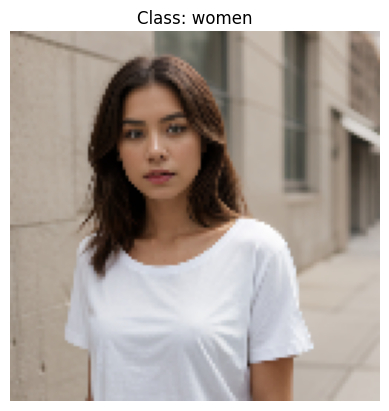

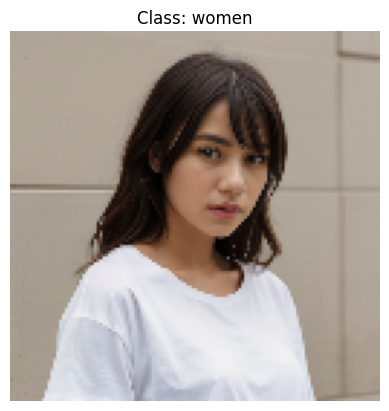

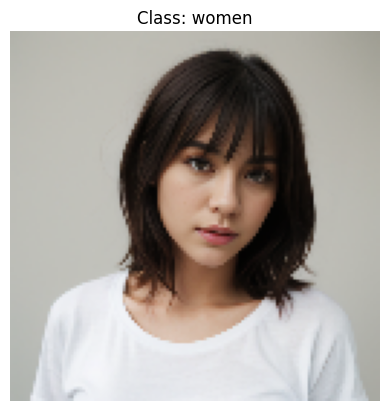

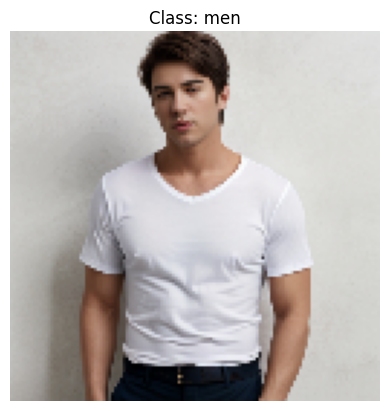

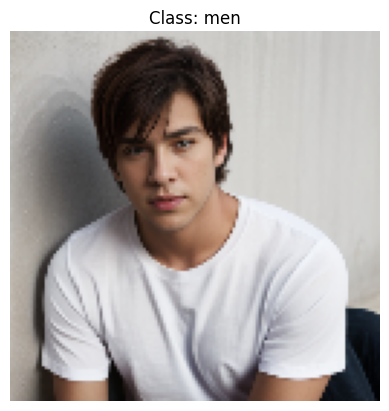

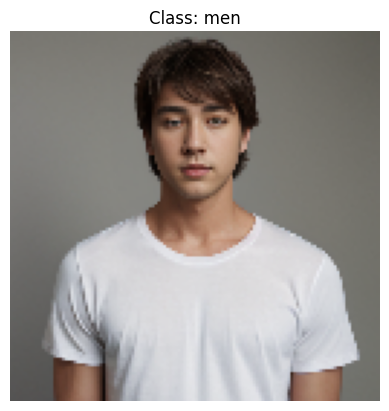

In [ ]:
# Her bir alt klasörden örnek görüntüler yükleyip gösterme
for subfolder in subfolders:
    sample_images = os.listdir(subfolder)[:3]  # İlk 3 görüntüyü al
    for img_name in sample_images:
        img_path = os.path.join(subfolder, img_name)
        img = load_image(img_path)
        plt.imshow(img)
        plt.title(f"Class: {os.path.basename(subfolder)}")
        plt.axis('off') #eksen numaraları görünmemesi için
        plt.show()

In [37]:
"""Model performansına göre hangilerinin kullanılacağı
değişiklik gösterir."""
#DATA CLEANING
def clean_image(image):
    # Gürültü azaltma
    denoised_img = cv2.GaussianBlur(image, (5, 5), 0)

    #keskinleştirme
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened_img = cv2.filter2D(denoised_img, -1, kernel)

    #BGR to HSV (Hue,Saturation, Value) dönüşümü
    hsv_img = cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2HSV)
    #mavi renk filtreleme için aralık ayarlama
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    #mavi renk aralığına göre maske oluşturma
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    #maske uygulanması
    result = cv2.bitwise_and(sharpened_img, sharpened_img, mask=mask)

    # Parlaklık ve kontrast ayarı
    adjusted_img = cv2.convertScaleAbs(sharpened_img, alpha=1.5, beta=10)



    return adjusted_img

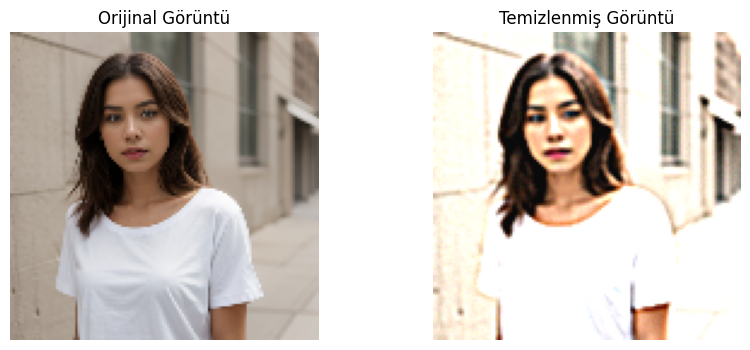

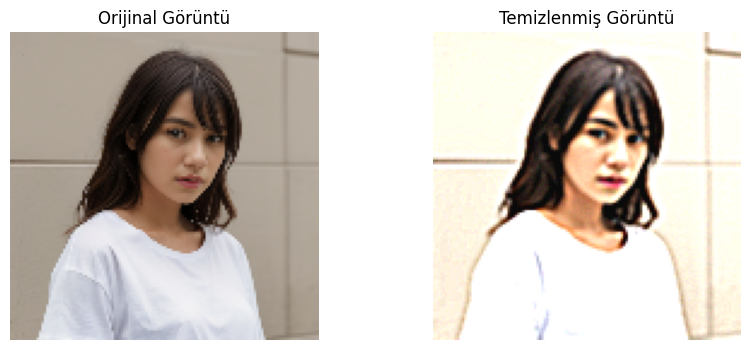

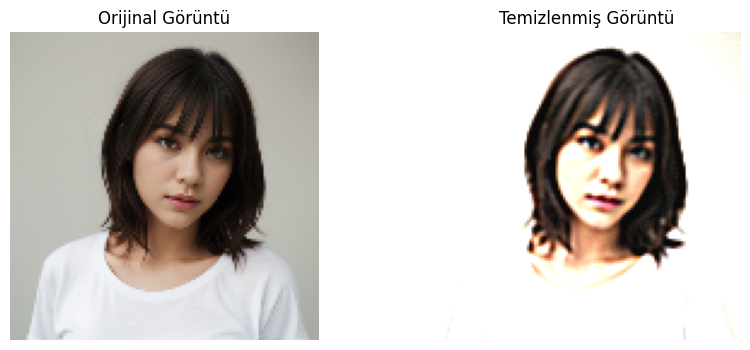

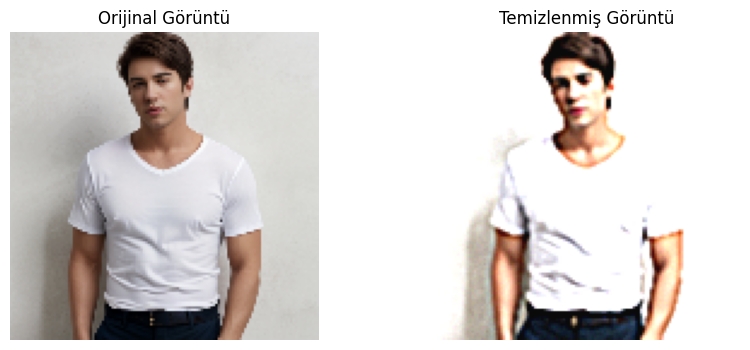

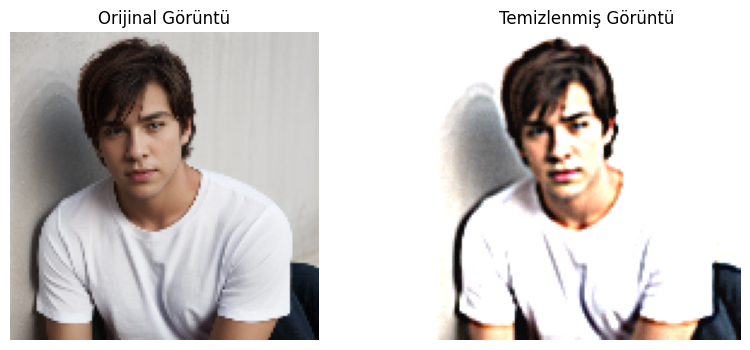

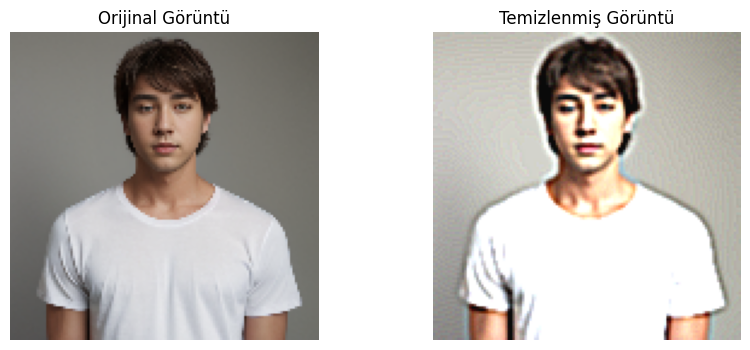

In [38]:
# Temizlenmiş görüntüleri gösterme
for subfolder in subfolders:
    sample_images = os.listdir(subfolder)[:3]  # İlk 3 görüntüyü al
    for img_name in sample_images:
        img_path = os.path.join(subfolder, img_name)
        img = load_image(img_path)
        cleaned_img = clean_image(img)  # Görüntüyü temizle

        # Orijinal ve temizlenmiş görüntüyü yan yana göster
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Orijinal Görüntü')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cleaned_img)
        plt.title('Temizlenmiş Görüntü')
        plt.axis('off')
        plt.show()


In [ ]:
#ImageDataGenerator classını başlatma
datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

In [ ]:
# Augmented görüntüleri kaydedeceğimiz dizin
output_dir = '/content/drive/MyDrive/ImageDetectionProject1/gender/augmented_images'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Görüntüleri çoğaltma ve kaydetme
def augment_images_from_folder(folder_path, output_folder):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # Görüntüyü yükle
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # (1, width, height, channels)

        # Görüntüyü çoğalt ve kaydet
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix='aug_', save_format='png'):
            i += 1
            if i >= 5:  # Her görüntüden 5 çoğaltılmış örnek oluştur
                break


In [ ]:
for subfolder in subfolders:
    subfolder_name = os.path.basename(subfolder)
    augmented_subfolder = os.path.join(output_dir, subfolder_name)
    os.makedirs(augmented_subfolder, exist_ok=True)
    augment_images_from_folder(subfolder, augmented_subfolder)


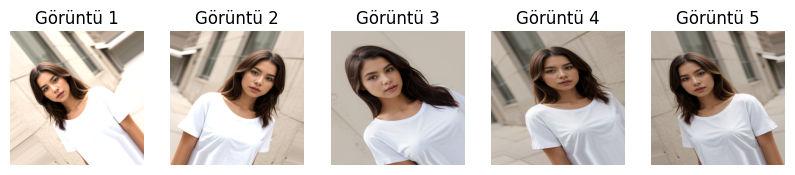

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_first_five_images(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith('png')][:5]
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):

        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Görüntü {i + 1}')
        plt.axis('off')
    plt.show()

# Örnek: 'augmented_images/women' dizinindeki ilk 35 çoğaltılmış görüntüyü gösterme
show_first_five_images(os.path.join(output_dir, 'women'))
